# Finding RNAfish spots in 256x256 images using Unet, Conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import glob

In [2]:
data='/media/smc/TransmittedYeastSpores/'

# Get data

Load data from file

In [3]:
shp=[1,256,256,5]

In [8]:
train_both=utils.get_raw_float_image(data+'Training.raw',shp)
train_data=train_both[:,:,:,[0]]/255.0
train_truth=train_both[:,:,:,[1,2]]
train_truth[:,:,:,0]=train_truth[:,:,:,0]/255.0
train_truth[:,:,:,1]=train_truth[:,:,:,1]/255.0

In [9]:
validation_both=utils.get_raw_float_image(data+'Validation.raw', shp)
validation_data=validation_both[:,:,:,[0]]/255.0
validation_truth=validation_both[:,:,:,[1,2]]
validation_truth[:,:,:,0]=validation_truth[:,:,:,0]/255.0
validation_truth[:,:,:,1]=validation_truth[:,:,:,1]/255.0

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [4]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 256,256,1], name='x')
y=tf.placeholder(dtype=tf.float32, shape=[None, 256,256,2], name='y')

xr=x
yr=y

base_scaler=32

#Going down
A1=(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME'))
A2=(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
F1=(tf.layers.conv2d(F0, 32*base_scaler, [3,3], padding='SAME'))
F2=(tf.layers.conv2d(F1, 32*base_scaler, [3,3], padding='SAME'))



#Coming up
EE0=tf.layers.conv2d_transpose(F2, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
EE1=tf.concat(axis=3, values=[EE0,E2])
EE2=(tf.layers.conv2d(EE1, 16*base_scaler, [3,3], padding='SAME'))
EE3=(tf.layers.conv2d(EE2, 16*base_scaler, [3,3], padding='SAME'))

DD0=tf.layers.conv2d_transpose(EE2, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=(tf.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=(tf.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=(tf.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=(tf.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#BB0=tf.contrib.layers.conv2d_transpose(C2, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=(tf.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=(tf.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=(tf.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

#logits=utils.leaky_relu(tf.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
logits=tf.nn.relu(tf.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
probs=tf.tanh(logits, name='probabilities')

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
OutError, MaskError=tf.split(LSQ, [1,1], 3)
loss=1*tf.reduce_mean(OutError)+1.0*tf.reduce_mean(MaskError)
#loss=tf.reduce_mean(LSQ, name='error')

train_op=tf.train.AdamOptimizer(learning_rate=0.0001, name='trainer').minimize(loss)

# Training on easy set

0
Training loss:  0.134688
(50, 256, 256, 2)
Validation loss:  0.139682


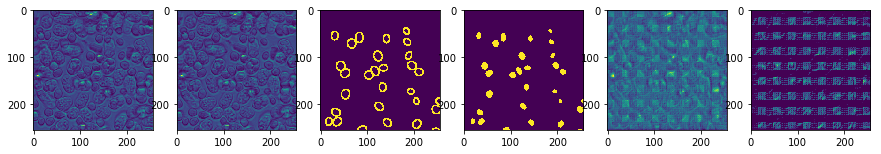

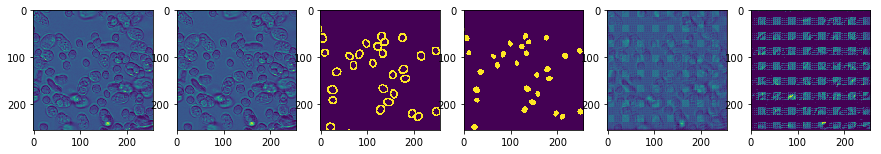

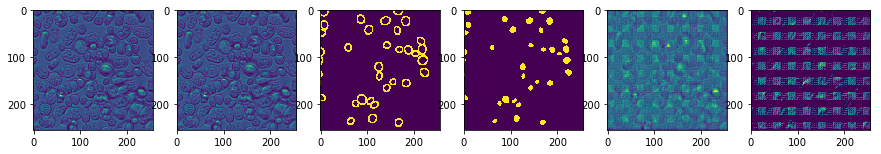

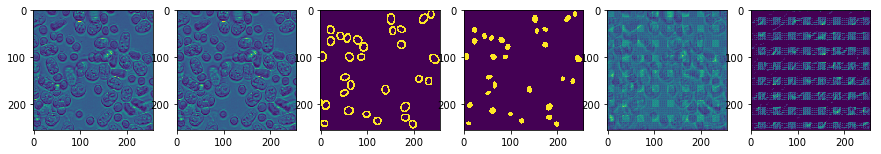

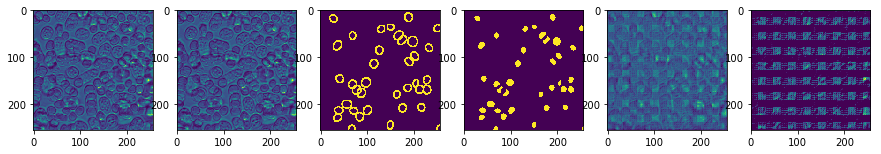

100
Training loss:  0.0749539
(50, 256, 256, 2)
Validation loss:  0.0929861


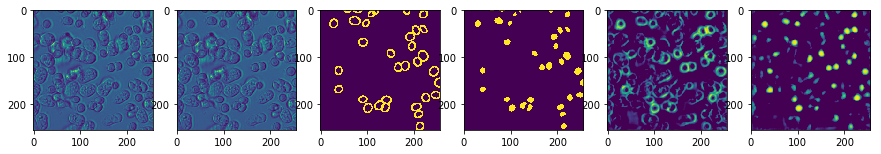

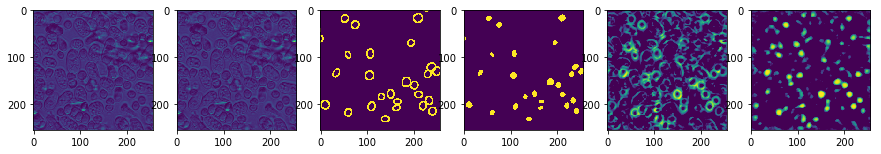

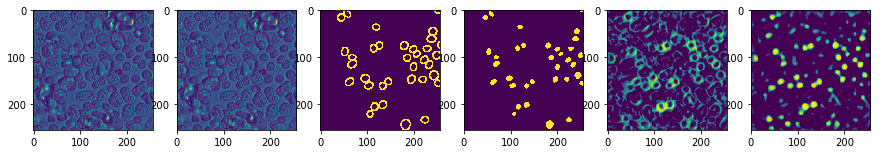

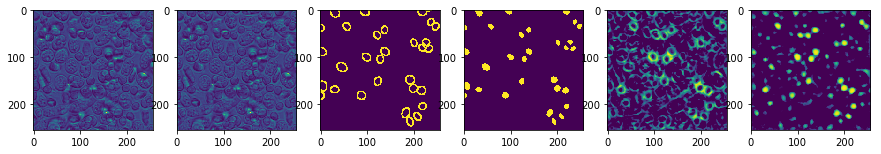

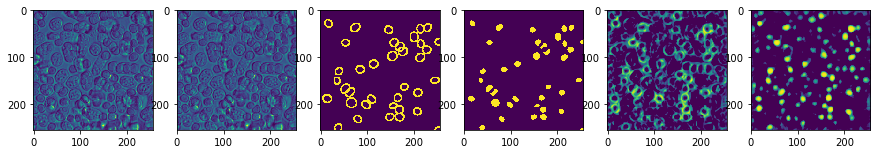

200
Training loss:  0.042552
(50, 256, 256, 2)
Validation loss:  0.0779697


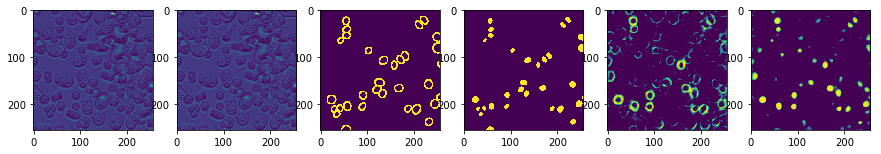

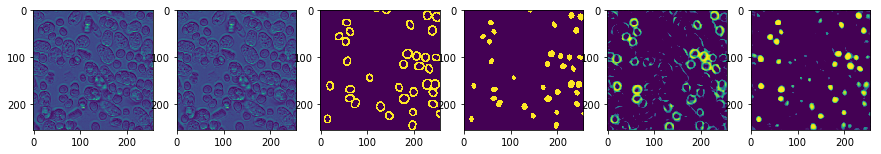

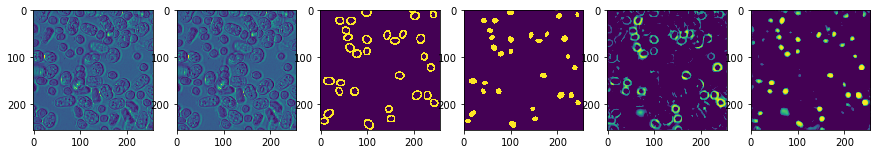

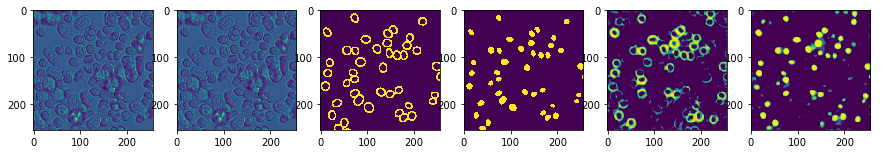

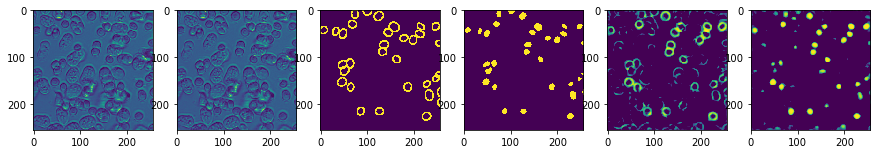

300
Training loss:  0.0341812
(50, 256, 256, 2)
Validation loss:  0.0790774


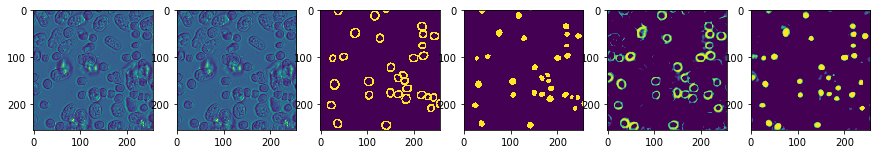

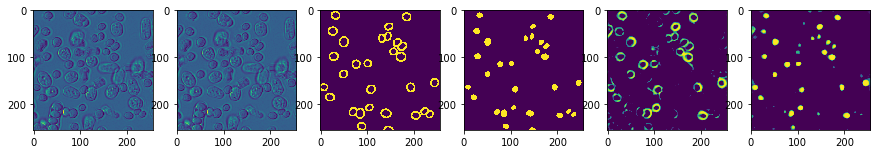

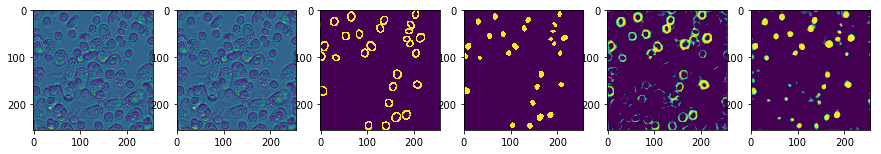

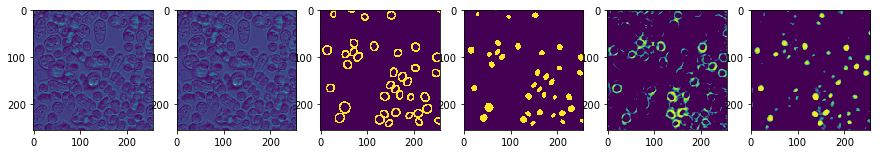

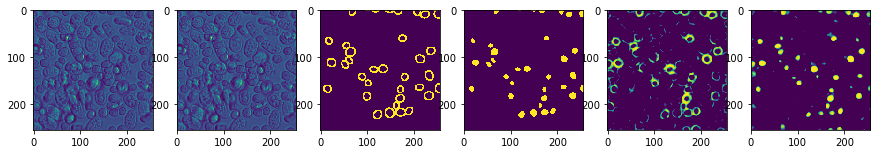

400
Training loss:  0.0290791
(50, 256, 256, 2)
Validation loss:  0.0838771


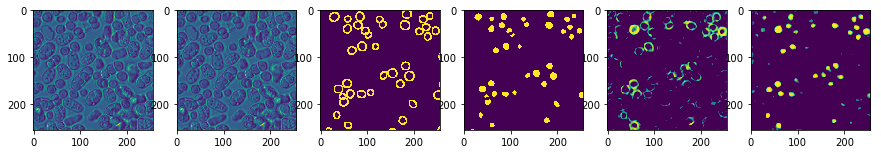

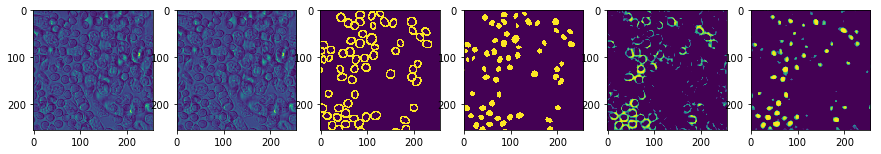

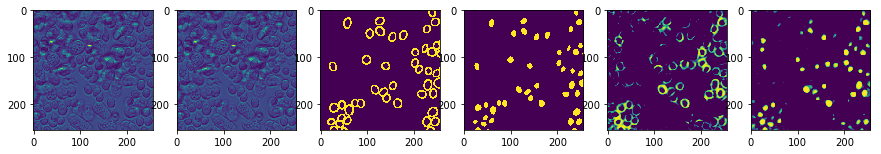

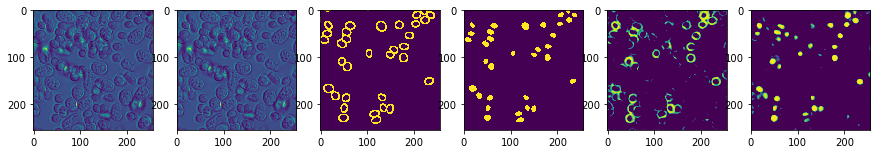

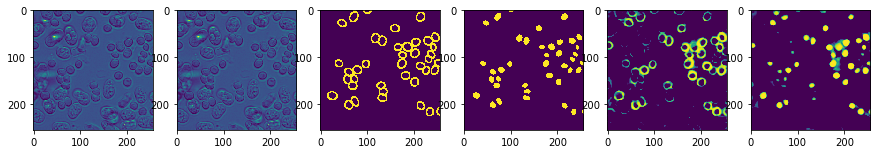

500
Training loss:  0.0255162
(50, 256, 256, 2)
Validation loss:  0.0846175


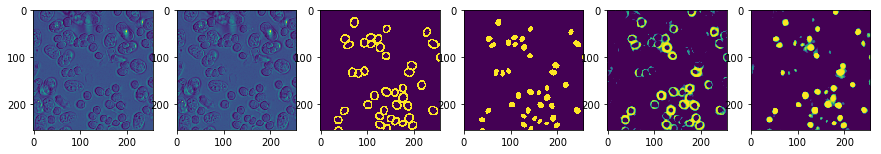

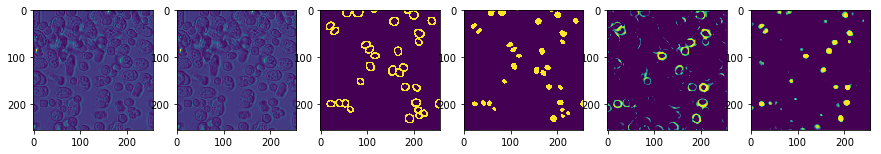

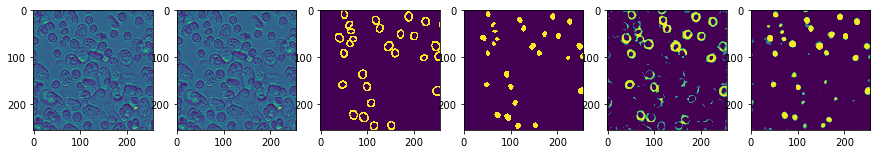

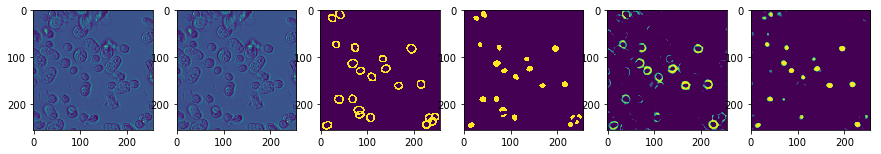

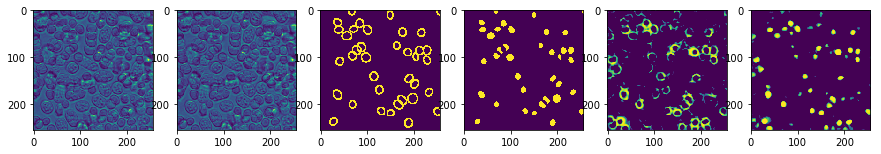

In [10]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(600):
    idx=np.random.choice(train_data.shape[0], replace=False, size=[50])
    cur_train=train_data[idx,:,:,:]
    cur_truth=train_truth[idx,:,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%100==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
        #idx=range(0,300)
        sub_validation_data=validation_data[idx, :,:,:]
        sub_validation_truth=validation_truth[idx, :,:]
        results, losses, a,c,cc=sess.run([probs, loss, A1,C2,CC2], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print(results.shape)
        print("Validation loss: ",losses)
        for ti in range (0,5):
            utils.plot_6x1(sub_validation_data[ti,:,:,0], sub_validation_data[ti,:,:,0], sub_validation_truth[ti,:,:,0], sub_validation_truth[ti,:,:,1],results[ti,:,:,0], results[ti,:,:,1])
            plt.show()
#saver = tf.train.Saver()
#saver.save(sess, data+'Model')

# Save

In [11]:
saver = tf.train.Saver()
saver.save(sess, data+'Spores/Model')

'/media/smc/TransmittedYeastSpores/Spores/Model'

# Process new datafiles using trained network

Load the network that works best

In [19]:
#tf.set_random_seed(123456)
#sess=tf.Session()
#sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()


data_model=data+'SporeSac'
saver.restore(sess,tf.train.latest_checkpoint(data_model))

INFO:tensorflow:Restoring parameters from /media/smc/TransmittedYeastSpores/SporeSac/Model


Function for processing a file

In [20]:
def process_file(sess, file_name):
    true_test2_data=utils.get_raw_float_image(file_name, [1,256,256,1])[:,:,:]/255.0
    true_test2_data=np.reshape(true_test2_data, (true_test2_data.shape[0],256,256,1))
    true_test2_truth=np.concatenate([true_test2_data, true_test2_data], axis=3)
    print(true_test2_data.shape)
    print(true_test2_truth.shape)
    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    #true_test2_data=true_test2_data/np.std(true_test2_data)*0.02
    #true_test2_data=true_test2_data-np.mean(true_test2_data)+0.55

    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,256,256,3])
    process_batch_size=50
    print('Starting')
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        sub_validation_truth=true_test2_truth[t:(t+process_batch_size), :,:]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        output[t:(t+process_batch_size),:,:,0]=sub_validation_data[:,:,:,0]
        output[t:(t+process_batch_size),:,:,1]=results[:,:,:,0]
        output[t:(t+process_batch_size),:,:,2]=results[:,:,:,1]
    print('Done')
    output=np.swapaxes(np.swapaxes(output,3,2),2,1)
    np.place(output, output<0, 0)
    (output*255.0).astype(np.uint8).tofile(file_name[0:-4]+'_outputb.raw')
    print(file_name[0:-4]+'_output.raw')
    return output


In [82]:
output=process_file(sess,data+'Test.raw')

(90, 256, 256, 1)
(90, 256, 256, 2)
0.0478713
0.184424
0.0478713
0.184424
Starting
Done
/media/smc/TransmittedYeastSpores/Test_output.raw


In [70]:
output.shape

(11583, 3, 256, 256)

In [22]:
for f in glob.glob(data+'ProcessMe'+'/*.raw'):
    output=process_file(sess,f)

(9, 256, 256, 1)
(9, 256, 256, 2)
0.0500378
0.141417
0.0500378
0.141417
Starting
Done
/media/smc/TransmittedYeastSpores/ProcessMe/2288x2167_dip4_asci7_channel_TL_only_output.raw
(9, 256, 256, 1)
(9, 256, 256, 2)
0.0503558
0.200747
0.0503558
0.200747
Starting
Done
/media/smc/TransmittedYeastSpores/ProcessMe/7-9-2018_2287x2167_dip4-asci8_channel_TL_only_output.raw
(9, 256, 256, 1)
(9, 256, 256, 2)
0.0538134
0.199493
0.0538134
0.199493
Starting
Done
/media/smc/TransmittedYeastSpores/ProcessMe/7-9-2018_2287x2167_dip4-asci9_channel_TL_only_output.raw
(9, 256, 256, 1)
(9, 256, 256, 2)
0.0478748
0.178854
0.0478748
0.178854
Starting
Done
/media/smc/TransmittedYeastSpores/ProcessMe/7-9-2018_2287x2167_dip4-asci5_channel_TL_only_output.raw
(9, 256, 256, 1)
(9, 256, 256, 2)
0.049033
0.140324
0.049033
0.140324
Starting
Done
/media/smc/TransmittedYeastSpores/ProcessMe/2288x2167_dip4_asci8_channel_TL_only_output.raw
(9, 256, 256, 1)
(9, 256, 256, 2)
0.0420757
0.177949
0.0420757
0.177949
Starting
Done